# (1 - RUN) Seting Import package and Parameter

ref : 

In [ ]:
#Set Environment and Parameter
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score ,f1_score ,precision_score ,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

import time

pd.set_option('display.max_columns', 100)



RANDOM_STATE = 2018
PREDS_RATIO = 0.5

# (2 - RUN) Prepar Data

## Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/creditcard.csv")
data_df.head(3)
print(f"Size od data frame {data_df.shape}")

Size od data frame (284807, 31)


In [ ]:
#Define predictors and target values
target = 'Class'
predictors = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10','V11', 'V12', 'V13', 'V14', 'V15',
                   'V16', 'V17', 'V18', 'V19','V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [ ]:
df_x = data_df[predictors]
df_y = data_df[target]

## Scaling predictors

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_x = pd.DataFrame(scaler.fit_transform(df_x))

## Split data in train, test

In [ ]:
TEST_SIZE = 0.20 # test size using_train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
print(f"Proportion of Target: {y_train.mean()}")

Proportion of Target: 0.0017204678619236761


## Oversampling Trainig Set

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = RANDOM_STATE ,sampling_strategy='minority')
x_train, y_train = smote.fit_resample(x_train,y_train)
print(f"Proportion after oversampling : {y_train.mean()}")

Proportion after oversampling : 0.5


## Prepare Data in Numpy

In [ ]:
#Predictor
x_train = x_train.values.astype(np.float32)
x_test  = x_test.values.astype(np.float32)
print( f" x_train.shape={x_train.shape}, x_train.dtype={x_train.dtype}, min(x_train)={np.min(x_train):0.4f}, max(x_train)={np.max(x_train):0.4f}")
print( f" x_test.shape={x_test.shape}, x_test.dtype={x_test.dtype}, min(x_test)={np.min(x_test):0.4f}, max(x_test)={np.max(x_test):0.4f}")

 x_train.shape=(454906, 29), x_train.dtype=float32, min(x_train)=0.0000, max(x_train)=1.0000
 x_test.shape=(56962, 29), x_test.dtype=float32, min(x_test)=0.0000, max(x_test)=1.0000


In [ ]:
#Target
y_train = y_train.values
y_test = y_test.values
print( f" y_train.shape={y_train.shape}, y_train.dtype={y_train.dtype}, min(y_train)={np.min(y_train)}, max(y_train)={np.max(y_train)}")
print( f" y_test.shape={y_test.shape}, y_test.dtype={y_test.dtype}, min(y_test)={np.min(y_test)}, max(y_test)={np.max(y_test)}")

 y_train.shape=(454906,), y_train.dtype=int64, min(y_train)=0, max(y_train)=1
 y_test.shape=(56962,), y_test.dtype=int64, min(y_test)=0, max(y_test)=1


# (Skip) Deep Learning MLP

## setting MPL Enviroment

In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import sys
import tensorflow as tf

In [ ]:
print(f"Python :{sys.version}\nNumpy:{np.__version__}\nTensorFlow{tf.__version__}")
print(f"tf.keras.backend.image_data_firmat() = {tf.keras.backend.image_data_format()}")
#Count the number ofGPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow detect {len(gpus)} GPUs")
for i,gpu in enumerate(gpus):
  print(f"> GPU No. {i} : Name = {gpu.name}  ,Type = {gpu.device_type}")

Python :3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Numpy:1.19.5
TensorFlow2.7.0
tf.keras.backend.image_data_firmat() = channels_last
TensorFlow detect 0 GPUs


In [ ]:
#seting
np.random.seed(1234)
tf.random.set_seed(5678)
_,input_dim = x_train.shape #the number of features per one input
output_din = len(set(y_train)) #the number of output classes

## Create the network architecture

In [ ]:
model = tf.keras.models.Sequential()

#Input layer
model.add(tf.keras.Input(shape=(input_dim,)))

#Hidden layer
model.add(tf.keras.layers.Dense(32, activation='relu', name='hidden1')) #use defult weight initialization, don't use any regularization
model.add(tf.keras.layers.BatchNormalization(axis =-1, name='bn1'))

#output layer
model.add(tf.keras.layers.Dense(output_din, activation='softmax', name='output'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 32)                960       
                                                                 
 bn1 (BatchNormalization)    (None, 32)                128       
                                                                 
 output (Dense)              (None, 2)                 66        
                                                                 
Total params: 1,154
Trainable params: 1,090
Non-trainable params: 64
_________________________________________________________________


## Compile the model

In [ ]:
#Examples of compiling the model (only run one cell provided below)
#1) complie with default values for both optimizer and loss
# model.compile( optimizer='adam', loss='sparse_categorical_croseentropy', metrics=['acc'])
#2) complie + Hyperparameter tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['acc'])

## Training the model

In [ ]:
start_tm = time.time()
checkpoint_filepath = "bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                               save_weights_only=True, 
                                                               monitor='val_acc', 
                                                               model='max', 
                                                               save_best_only=True)
history = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2, callbacks=[model_checkpoint_callback])
print(f">>>>> Training Time >>>> {time.time() - start_tm} seconds")

Epoch 1/20
2844/2844 [==============================] - 7s 2ms/step - loss: 0.1409 - acc: 0.9455 - val_loss: 0.0602 - val_acc: 0.9736
Epoch 2/20
2844/2844 [==============================] - 6s 2ms/step - loss: 0.1115 - acc: 0.9562 - val_loss: 0.2672 - val_acc: 0.8931
Epoch 3/20
2844/2844 [==============================] - 7s 3ms/step - loss: 0.1021 - acc: 0.9589 - val_loss: 0.1791 - val_acc: 0.9111
Epoch 4/20
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0965 - acc: 0.9604 - val_loss: 0.1940 - val_acc: 0.9095
Epoch 5/20
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0919 - acc: 0.9621 - val_loss: 0.2406 - val_acc: 0.8893
Epoch 6/20
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0862 - acc: 0.9642 - val_loss: 0.1061 - val_acc: 0.9480
Epoch 7/20
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0825 - acc: 0.9662 - val_loss: 0.0689 - val_acc: 0.9674
Epoch 8/20
2844/2844 [==============================] - 6s 2ms

In [ ]:
#Inspect the save file (sorted by modification date,  newest first)
!ls -lt

total 56
-rw-r--r-- 1 root root 21056 Feb  1 14:27 bestmodel_epoch16_valloss0.04.hdf5
-rw-r--r-- 1 root root 21056 Feb  1 14:26 bestmodel_epoch01_valloss0.06.hdf5
drwx------ 5 root root  4096 Feb  1 14:24 drive
drwxr-xr-x 1 root root  4096 Jan  7 14:33 sample_data


## Model Performance

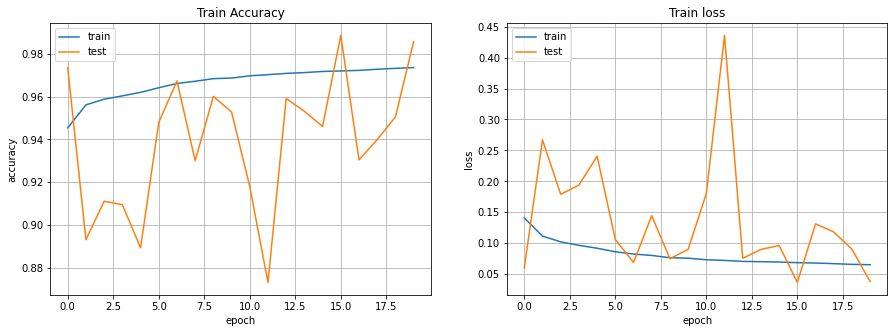

In [ ]:
#summary history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'] ,loc='upper left')
plt.grid()

#summary history for loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'] ,loc='upper left')
plt.grid()
plt.show()

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=128)
print(f"{model.metrics_names} = {results}")

446/446 [==============================] - 1s 1ms/step - loss: 0.1023 - acc: 0.9620
['loss', 'acc'] = [0.10229665040969849, 0.9619746208190918]


In [ ]:
preds_mlp = model.predict(x_test)

In [ ]:
pfm_auc = roc_auc_score(y_test, preds_mlp[:,1])
pfm_f1 = f1_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')
pfm_precision = precision_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')
pfm_recall = recall_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')
print(f"AUC:{pfm_auc}\nF1 Score:{pfm_f1}\nPrecision:{pfm_precision}\nRecall:{pfm_recall}")

AUC:0.9628028384509866
F1 Score:0.9789997560795598
Precision:0.9981133935255428
Recall:0.961974649766511


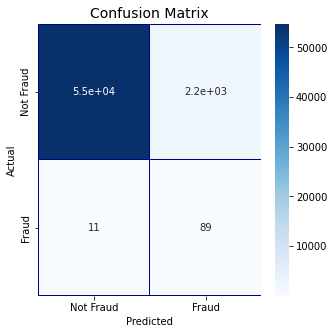

In [ ]:
cm = pd.crosstab(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# (3 - Run) Loop Training DP-MLP

## Set seed

In [ ]:
import sys
import tensorflow as tf
#seting
np.random.seed(1234)
tf.random.set_seed(5678)
_,input_dim = x_train.shape #the number of features per one input
output_din = len(set(y_train)) #the number of output classes

## Create Function and setting model

In [ ]:
def mlp_training(batchSize ,epochNum ,learnRate ,optzer ,nodes_num=1 ,nodes_act='relu'):
  model = tf.keras.models.Sequential()
  #Input layer
  model.add(tf.keras.Input(shape=(input_dim,)))
  #Hidden -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
  #> 1 layer
  model.add(tf.keras.layers.Dense(nodes_num, activation=nodes_act, name='hidden1')) 
  model.add(tf.keras.layers.BatchNormalization(axis =-1, name='bn1'))
  #> 2 layer
  model.add(tf.keras.layers.Dense(nodes_num, activation=nodes_act, name='hidden2')) 
  model.add(tf.keras.layers.BatchNormalization(axis =-1, name='bn2'))  
  #> 3 layer
  model.add(tf.keras.layers.Dense(nodes_num, activation=nodes_act, name='hidden3')) 
  model.add(tf.keras.layers.BatchNormalization(axis =-1, name='bn3'))  
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  #output layer
  model.add(tf.keras.layers.Dense(2, activation='softmax' , name='output'))

  #Compiling the model
  if optzer.lower() == 'adum':
    opt = tf.keras.optimizers.Adam(learning_rate=learnRate)
  elif optzer.lower() == 'sgd':
    opt = tf.keras.optimizers.SGD(learning_rate=learnRate)
  else :
    print('error optimizers')
  model.compile(optimizer=opt
                      , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
                      , metrics=['acc'])
  #Training
  history = model.fit(x_train, y_train, batch_size=batchSize, epochs=epochNum, verbose=0, validation_split=0.2)
  return model,history

## Test Function create model

In [ ]:
start_tm = time.time()
model,history = mlp_training(256, 250 ,0.01 ,'adum' ,56 ,'relu')
training_tm = time.time() - start_tm

KeyboardInterrupt: ignored

In [ ]:
preds_mlp = model.predict(x_test)

In [ ]:
preds_mlp = model.predict(x_test)
pfm_auc = roc_auc_score(y_test, preds_mlp[:,1])
pfm_f1 = f1_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')
pfm_precision = precision_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')
pfm_recall = recall_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')
print(f"AUC:{pfm_auc}\nF1 Score:{pfm_f1}\nPrecision:{pfm_precision}\nRecall:{pfm_recall}")

## Loop

In [ ]:
#list of Parameter batchSize ,epochNum ,learnRate ,optzer ,nodes_num=1 ,nodes_act='relu'
lst_batch = [256, 512, 1024]
lst_epoch = [10, 25, 50]
lst_learn = [0.001 ,0.005]
lst_opt = ['adum' ,'sgd']
lst_node = [56]
lst_activation = ['sigmoid', 'relu']

In [ ]:
#Import last result
#For New Loop
df_result_MLP = pd.DataFrame()
#Continue from last state
#df_result_MLP = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/mlp_result_l007_c015.csv')
last_step = len(df_result_MLP)
print(f"Last step is : {last_step}")
df_result_MLP.tail(2)

Last step is : 0


""


In [ ]:
count_loop = 0
start_tm = time.time()
for batch_i in lst_batch:
  for epoch_j in lst_epoch:
    for learn_k in lst_learn:
      for opt_l in lst_opt:
        for node_m in lst_node:
          for act_n in lst_activation:
            count_loop =count_loop+1
            if count_loop>last_step:
              inloop_tm = time.time()
              model,_ = mlp_training(batch_i,epoch_j,learn_k,opt_l,node_m,act_n)
              inloop_tm = time.time() - inloop_tm
              preds_mlp = model.predict(x_test)
              results = model.evaluate(x_test, y_test, batch_size=128 , verbose=0)
              #Save Result
              result_dic = {'batch_size':[batch_i]
                              ,'epoch':[epoch_j]
                              ,'learning_rate':[learn_k]
                              ,'optimizer':[opt_l]
                              ,'num_node':[node_m]
                              ,'activation':[act_n]
                              ,'layers':['|'.join([layer.name for layer in model.layers])]
                              ,'runing_times':[inloop_tm]
                              ,'auc':[roc_auc_score(y_test, preds_mlp[:,1])]
                              ,'f1score':[f1_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')]
                              ,'precision':[precision_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')]
                              ,'recall':[recall_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')]
                              ,'loss':[results[0]]
                              ,'acc':[results[1]]
                              }
              df_result_MLP = df_result_MLP.append(pd.DataFrame(result_dic) ,ignore_index=True)
              print(f"Size of table {df_result_MLP.shape} time: {(time.time() - start_tm)/60:.2f} min")
              #Save Result to google Drive
              df_result_MLP.to_csv(f"/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/mlp_result_l{len(model.layers):03d}_c{count_loop:03d}.csv",index=False)
            else :
              print(f"Skip step : {count_loop}")
print(f"Total runing loop : {time.time() - start_tm}")

Size of table (1, 14) time: 0.76 min
Size of table (2, 14) time: 1.52 min
Size of table (3, 14) time: 2.17 min
Size of table (4, 14) time: 2.84 min
Size of table (5, 14) time: 3.59 min
Size of table (6, 14) time: 4.34 min
Size of table (7, 14) time: 5.10 min
Size of table (8, 14) time: 5.85 min
Size of table (9, 14) time: 7.60 min
Size of table (10, 14) time: 9.35 min
Size of table (11, 14) time: 10.88 min
Size of table (12, 14) time: 13.32 min
Size of table (13, 14) time: 15.76 min
Size of table (14, 14) time: 18.20 min
Size of table (15, 14) time: 19.71 min
Size of table (16, 14) time: 21.26 min
Size of table (17, 14) time: 24.69 min
Size of table (18, 14) time: 29.12 min
Size of table (19, 14) time: 32.15 min
Size of table (20, 14) time: 35.30 min
Size of table (21, 14) time: 38.83 min
Size of table (22, 14) time: 43.27 min
Size of table (23, 14) time: 46.29 min
Size of table (24, 14) time: 49.34 min
Size of table (25, 14) time: 49.86 min
Size of table (26, 14) time: 50.62 min
Size 